### Занятие №11: Немного чистой архитектуры на примере задачи

##### <span style="color:#0ab49a">Задача:</span> смоделировать функции, вычисляющие RSSI с одной полуволновой антенны на другую 
- Формула передачи Фрииса: $$\frac{P_r}{P_t}=G_t G_r \left( \frac{\lambda}{4\pi R} \right)^2$$
- Коэффициент усиления полуволнового диполя: *(Silver S. Microwave Antenna Theory and Design // McGraw Hill Book Company. 1984. pp. 98–99.)* $$G=\frac{\cos\left(\frac{\pi}{2}\cos\theta\right)}{\sin\theta}$$

##### SOLID
1. <u>Принцип единственной ответственности</u><br>
        У каждого класса только 1 ответственность; у него нет других обязанностей
2. <u>Принцип открытости/закрытости</u><br>
        Сущности (классы, модули, функции) октрыты для расширения, но закрыты для изменений
3. <u>Принцип подстановки Лисков</u><br>
        Функции, которые используют базовый тип, должны иметь возможность использовать подтипы базового типа, не зная об этом.
4. <u>Принцип разделения интерфейса</u><br>
        Ни один клиент не должен зависеть от методов, которые он не использует
5. <u>Принцип инверсии зависимостей</u><br>
        Абстракции не должны зависеть от деталей. Детали должны зависеть от абстракций.

##### Структура кода

1. Класс "Девайс" $\to$ `objects.py`
2. Рассчёт G $\to$ `measures.py`
3. Математика $\to$ `my_math.py`
4. Отображение $\to$ `my_plot.py`

<u>Модуль нашей математики</u>

In [1]:
import numpy as np

def sperical2dec(r, u, v):
    return np.array([r*np.cos(u)*np.cos(v),
                     r*np.cos(u)*np.sin(v),
                     r*np.sin(u)])

def cross(a, b):
    return np.cross(a, b)

<u>Функция рассчёта коэффициента усиления</u>

In [2]:
import numpy as np

def get_G1(d1 = None, d2 = None, antenna_brf: str = 'z', r_12_brf: np.ndarray = None) -> float:
    """
    Функция берёт либо объекты класса Device: d1, d2, либо радиус-вектор r_12_brf
    :param d1: Описание аргумента
    :return: Описание возвращаемой переменной
    """
    # from my_math import cross
    
    if r_12_brf is None:
        if not (isinstance(d1, Device) and isinstance(d2, Device)):
            raise TypeError(f"Текст ошибки")
    
    if antenna_brf not in ['x', 'y', 'z']:
        raise ValueError(f"Текст ошибки")
        
    A = quaternion.as_rotation_matrix(d1.q) if r_12_brf is None else np.eye(3)
    r_antenna_brf = np.array([int(antenna_brf=='x'), int(antenna_brf=='y'), int(antenna_brf=='z')])
    r_antenna_irf = A.T @ r_antenna_brf
    r_12 = d2.r - d1.r if r_12_brf is None else r_12_brf

    t_12 = r_12 / np.linalg.norm(r_12)
    t_a = r_antenna_irf / np.linalg.norm(r_antenna_irf)

    sin_theta = np.linalg.norm(cross(t_a, t_12))
    cos_theta = np.dot(t_a, t_12)
    
    return float(np.cos(np.pi / 2 * cos_theta) / sin_theta)

<u>Класс "Девайс"</u>

In [3]:
import numpy as np
import quaternion

class Device:
    def __init__(self, r: np.ndarray | list, q: quaternion.quaternion):
        self.P_transmit = 1.
        self.signal_length = 1.
        self.r = np.array(r)
        self.q = q.normalized()

    def get_recieved_rssi(self, d):
        # from measures import get_G1
        
        G1 = get_G1(d1=self, d2=d)
        G2 = get_G1(d1=d, d2=self)
        R = np.linalg.norm(self.r - d.r)
        
        return d.P_transmit * G1 * G2 * (d.signal_length / 4 / np.pi / R)**2

d1 = Device(r=[1, 0, 0], q=np.quaternion(1, 0, 1, 0))
d2 = Device(r=[0, 1, 0], q=np.quaternion(1, 1, 0, 0))

print(f"RSSI 2->1: {d1.get_recieved_rssi(d2)}")
print(f"RSSI 1->2: {d2.get_recieved_rssi(d1)}")

RSSI 2->1: 0.0012484673805595549
RSSI 1->2: 0.0012484673805595549


<u>Отображение</u>

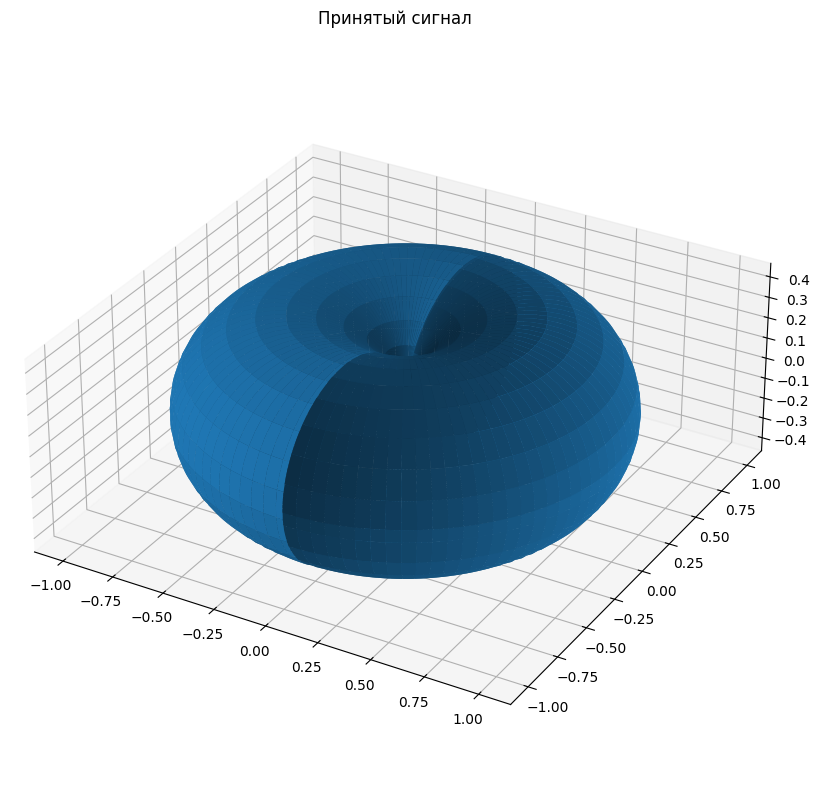

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_gain(d: Device, n: int = 20):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')

    u = np.linspace(0, 2 * np.pi, n)
    v = np.linspace(-np.pi / 2, np.pi / 2, n)
    U, V = np.meshgrid(u, v)

    g = np.array([[get_G1(r_12_brf=sperical2dec(r=1, u=u[ii], v=v[jj])) for ii in range(n)] for jj in range(n)])
    
    X, Y, Z = sperical2dec(g, U, V)
    ax.plot_surface(X, Y, Z)
    ax.set_box_aspect([1, 1, 1])
    ax.set_title("Принятый сигнал")
    ax.set_aspect('equal')
    plt.show()
    
plot_model_gain(d1, n=100)

<u>Тестирование (unittest / pytest)</u>

In [5]:
# Не успели на семинаре

**Вопрос**: *Что надо изменить, чтобы помимо мощности принимаемого сигнала измерять ещё и фазу?*

##### <span style="color:#0ab49a">Примечание:</span> Кватернионы в ПО

**Инициализация**

In [6]:
import numpy as np
import quaternion

for q in [np.quaternion(1, 0, 0, 0),
          np.quaternion(1, 2, 3, 4),
          np.quaternion(5, 0, 0),
          np.quaternion(5),
          np.quaternion()]:
    print(f"q = {q}")

q = np.quaternion(1, 2, 3, 4)

q = quaternion(1, 0, 0, 0)
q = quaternion(1, 2, 3, 4)
q = quaternion(0, 5, 0, 0)
q = quaternion(5, 0, 0, 0)
q = quaternion(0, 0, 0, 0)


In [7]:
a = np.array([0, 0, 0.5])

q1 = quaternion.from_vector_part(a)
q2 = quaternion.from_euler_angles(a)

q3 = np.quaternion(np.sqrt(1 - np.linalg.norm(a)**2), *a)

print(f"Кватернион из вектора: {q1}")
print(f"Кватернион единичный из вектора: {q3}")
print(f"Кватернион из углов Эйлера: {q2}")

Кватернион из вектора: quaternion(0, 0, 0, 0.5)
Кватернион единичный из вектора: quaternion(0.866025403784439, 0, 0, 0.5)
Кватернион из углов Эйлера: quaternion(0.968912421710645, 0, 0, 0.247403959254523)


**Преобразования типов**

In [8]:
a = quaternion.as_float_array(q)
b = quaternion.np.array(q)
c = quaternion.np.asarray(q)
d = q.components

print(f"Как numpy-массив: {a}")
print(type(a))
print(f"Как numpy-массив: {b}")
print(type(b))
print(f"Как numpy-массив: {c}")
print(type(c))
print(f"Как numpy-массив: {d}")
print(type(d))

Как numpy-массив: [1. 2. 3. 4.]
<class 'numpy.ndarray'>
Как numpy-массив: quaternion(1, 2, 3, 4)
<class 'numpy.ndarray'>
Как numpy-массив: quaternion(1, 2, 3, 4)
<class 'numpy.ndarray'>
Как numpy-массив: [1. 2. 3. 4.]
<class 'numpy.ndarray'>


**Преобразовани математические**

In [9]:
a = q.real
b = q.vec
w = q.w
x = q.x
y = q.y
z = q.z

print(f"Скалярная часть: {a}")
print(type(a))
print(f"Векторная часть: {b}")
print(type(b))
print(f"Составлющие: {w} {x} {y} {z}")
print(type(w), type(x), type(y), type(z))

Скалярная часть: 1.0
<class 'float'>
Векторная часть: [2. 3. 4.]
<class 'numpy.ndarray'>
Составлющие: 1.0 2.0 3.0 4.0
<class 'float'> <class 'float'> <class 'float'> <class 'float'>


In [10]:
a = quaternion.np.normalized(q)
b = q.normalized()

print(f"Нормированный кватернион: {a}")
print(type(a))

print(f"Нормированный кватернион: {b}")
print(type(b))

Нормированный кватернион: quaternion(0.182574185835055, 0.365148371670111, 0.547722557505166, 0.730296743340221)
<class 'quaternion.quaternion'>
Нормированный кватернион: quaternion(0.182574185835055, 0.365148371670111, 0.547722557505166, 0.730296743340221)
<class 'quaternion.quaternion'>


In [11]:
a = quaternion.np.abs(q)
b = quaternion.np.absolute(q)
d = q.abs()

c = quaternion.np.norm(q)

print(f"Модуль: {a} | {b} | {d}")
print(type(a), type(b), type(d), '\n')

print(f"Норма: {c} (√c = {np.sqrt(c)})")
print(type(c))

Модуль: 5.477225575051661 | 5.477225575051661 | 5.477225575051661
<class 'numpy.float64'> <class 'numpy.float64'> <class 'float'> 

Норма: 30.0 (√c = 5.477225575051661)
<class 'numpy.float64'>


In [12]:
a = quaternion.np.angle_of_rotor(q)
b = q.angle()

print(f"Угол поворота: {a} | {b}")
print(type(a), type(b))

Угол поворота: 4.389231563842282 | 4.389231563842282
<class 'numpy.float64'> <class 'float'>


In [13]:
a = q.conj()
b = q.conjugate()

с = q.inverse()
d = q.reciprocal()

print(f"Сопряженный: {a} | {b}")
print(type(a), type(b), '\n')

print(f"Обратный: {с} | {d}")
print(type(с), type(d))

Сопряженный: quaternion(1, -2, -3, -4) | quaternion(1, -2, -3, -4)
<class 'quaternion.quaternion'> <class 'quaternion.quaternion'> 

Обратный: quaternion(0.0333333333333333, -0.0666666666666667, -0.1, -0.133333333333333) | quaternion(0.0333333333333333, -0.0666666666666667, -0.1, -0.133333333333333)
<class 'quaternion.quaternion'> <class 'quaternion.quaternion'>


In [14]:
A = quaternion.as_rotation_matrix(q)
B = quaternion.as_rotation_matrix(q.normalized())

print(f"Матрица поворота из кватерниона A: \n{A}")
print(f"Матрица поворота из кватерниона B: \n{B}")

Матрица поворота из кватерниона A: 
[[-0.66666667  0.13333333  0.73333333]
 [ 0.66666667 -0.33333333  0.66666667]
 [ 0.33333333  0.93333333  0.13333333]]
Матрица поворота из кватерниона B: 
[[-0.66666667  0.13333333  0.73333333]
 [ 0.66666667 -0.33333333  0.66666667]
 [ 0.33333333  0.93333333  0.13333333]]
